In [1]:
import sys
sys.path.append('../')

import os
from glob import glob
from os.path import join as pjoin
from tqdm.auto import tqdm
from collections import OrderedDict

import torch
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
import albumentations as albu
import torchvision.transforms as T
import segmentation_models_pytorch as smp

import timm

from datasets import RANZCRDataset, RANZCRSegementationDataset, RANZCRMixedDataset
from datasets.mixed_dataset import RANZCRMixedDataset
from utils.fmix_utils import sample_mask, make_low_freq_image, binarise_mask
from models import CNNSegModel, CNNPreatrainModel, CNNPreatrainModelSeg
from utils.constants import CLASSES_CHESTX, CLASSES

from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
df = pd.read_csv('../pseudo/timm_efficientnet_b5_unet_24bs_640res_qubvelaugs_ls005_shedchanged_startpoint_difflrs_segbranch_113coefs_swa_roc_auc_flips_transp_01_025.csv')

In [ ]:
df = df.rename(columns={
    "Image Index":"StudyInstanceUID"
})

df

In [ ]:
df.to_csv("../pseudo/timm_efficientnet_b5_unet_24bs_640res_qubvelaugs_ls005_shedchanged_startpoint_difflrs_segbranch_113coefs_swa_roc_auc_flips_transp_01_025.csv", index=False)

In [ ]:
chckp = torch.load('../kaggle_checkpoints/timm_efficientnet_b5_pretrain_chestx_32bs_640res_qubvelaugs_rotaugs_ls005_shedchanged_swa_loss_fold_0.pt')

In [ ]:
OrderedDict({k:v for k,v in chckp.items() if k.startswith('classifier')})

In [ ]:
len(CLASSES_CHESTX[1:])

In [ ]:
temp_model = CNNPreatrainModelSeg(**{
            "classifiier_config": {
                "classifier_type": "drop_linear",
                "classes_num": 16,
                "main_classes_num": 11,
                "hidden_dims":1024,
                "first_dropout_rate": 0.3,
                "second_dropout_rate": 0.2,
            },
            "encoder_config": {
                "in_channels": 1,
                "encoder_name": "densenet121",
                "encoder_weights": None,
                "classes": 12,
                "activation": "sigmoid",
                "aux_params": dict(
                    pooling="avg",  # one of 'avg', 'max'
                    dropout=None,  # dropout ratio, default is None
                    classes=4,  # define number of output labels
                ),
            },
            "encoder_type": "timm-efficientnet-b5_unet",
            "path_to_chkp": '../pretrained/timm_efficientnet_b5_pretrain_chestx_32bs_640res_qubvelaugs_rotaugs_ls005_shedchanged_swa_loss_fold_0.pt'
        }, device='cpu')

In [ ]:
temp_model

In [ ]:
temp_model = CNNPreatrainModel(**{
            "classifiier_config": {
                "classifier_type": "drop_linear",
                "classes_num": 16,
                "hidden_dims":1024,
                "second_dropout_rate": 0.2,
            },
            "encoder_config": {
                "in_channels": 1,
                "encoder_name": "timm-efficientnet-b5",
                "encoder_weights": "noisy-student",
                "classes": 12,
                "activation": "sigmoid",
                "aux_params": dict(
                    pooling="avg",  # one of 'avg', 'max'
                    dropout=None,  # dropout ratio, default is None
                    classes=4,  # define number of output labels
                ),
            },
            "encoder_type": "timm-efficientnet-b5_unet",
        }, device='cpu')

In [ ]:
temp_model.forward(torch.rand(2,1,640,640))

In [ ]:
temp_model = CNNSegModel(**{
            "classifiier_config": {
                "classifier_type": "double_elu_mlp",
                "classes_num": 11,
                "hidden_classes_num": 4,
                "hidden_dims": 1024,
                "second_dropout_rate": 0.2,
                "first_dropout_rate": 0.3,
            },
            "encoder_config": {
                "in_channels": 3,
                "encoder_name": "timm-efficientnet-b5",
                "encoder_weights": None,
                "classes": 12,
                "activation": "sigmoid",
                "aux_params": dict(
                    pooling="avg",  # one of 'avg', 'max'
                    dropout=None,  # dropout ratio, default is None
                    classes=4,  # define number of output labels
                ),
            },
            "encoder_type": "timm-efficientnet-b5_unet",
            "use_taylorsoftmax": False,
            "one_channel": True,
            "path_to_chkp": "/data/additional_data/startingpoints/tf_efficientnet_b5_ns_chestx.pth",
        }, device='cpu')

In [ ]:
chckp = torch.load('../logdirs/timm_efficientnet_b5_unet_24bs_640res_qubvelaugs_rotaugs_ls005_shedchanged_startpoint_difflrs_segbranch_124coefs_1e4noseg_multichanneltube_mtm/fold_0/checkpoints/last.pth', 
                   map_location='cpu')['model_state_dict']

In [ ]:
temp_model.load_state_dict(chckp)

In [ ]:
temp_model(torch.randn(1,1,256,256))[0].shape

# Data

In [3]:
PATH2DIR = '/data'
os.listdir(PATH2DIR)

train = pd.read_csv(pjoin(PATH2DIR, 'train.csv'))
#train_anot = pd.read_csv(pjoin(PATH2DIR, 'train_only_anot.csv'))
#train_not_anot = pd.read_csv(pjoin(PATH2DIR, 'train_without_anot.csv'))

In [18]:
pseudo = pd.read_csv("../pseudo/timm_efficientnet_b5_unet_24bs_640res_qubvelaugs_ls005_shedchanged_startpoint_difflrs_segbranch_113coefs_1e4noseg_bigholes_swa_roc_auc_flips_transp_01_025.csv")
pseudo

StudyInstanceUID  Patient ID  Patient Age  Patient Gender  View Position  \
0        00000016_000          16     1.431036               0              0   
1        00000017_002          17     1.846715               0              1   
2        00000025_000          25     1.431036               0              0   
3        00000032_005          32     0.480913               1              1   
4        00000032_019          32     0.480913               1              1   
...               ...         ...          ...             ...            ...   
9403     00030777_000       30777     0.183999               1              0   
9404     00030783_000       30783     0.599678               0              0   
9405     00030788_000       30788     0.837209               1              0   
9406     00030791_001       30791     0.124617               0              1   
9407     00030795_000       30795     0.362148               1              0   

      Hernia  Atelectasis  Nodule  Effusion  Cardiomegaly  ...  \
0          0            0       0         0             0  ...   
1          0            0       0         0             0  ...   
2          0            0       0         1             0  ...   
3          0            0       0         0             0  ...   
4          0            0       0         0             0  ...   
...      ...          ...     ...       ...           ...  ...   
9403       0            0       0         0             0  ...   
9404       0            0       0         0             0  ...   
9405       0            0       0         0             0  ...   
9406       0            0       0         0             0  ...   
9407       0            0       0         0             0  ...   

      ETT - Borderline  ETT - Normal  NGT - Abnormal  NGT - Borderline  \
0                    0             0               0                 0   
1                    0             0               0                 0   
2                    0             0               0                 0   
3                    0             0               0                 0   
4                    0             0               0                 0   
...                ...           ...             ...               ...   
9403                 0             0               0                 0   
9404                 0             0               0                 0   
9405                 0             0               0                 0   
9406                 0             0               0                 0   
9407                 0             0               0                 0   

      NGT - Incompletely Imaged  NGT - Normal  CVC - Abnormal  \
0                             0             0               0   
1                             0             0               0   
2                             0             0               0   
3                             0             0               0   
4                             0             0               0   
...                         ...           ...             ...   
9403                          0             0               0   
9404                          0             0               0   
9405                          0             0               0   
9406                          0             0               0   
9407                          0             0               0   

      CVC - Borderline  CVC - Normal  Swan Ganz Catheter Present  
0                    0             1                           0  
1                    0             1                           0  
2                    1             0                           0  
3                    0             1                           0  
4                    0             1                           0  
...                ...           ...                         ...  
9403                 0             1                           0  
9404                 0           

In [ ]:
from os.path import splitext

In [ ]:
train['Image Index'] = train['Image Index'].apply(lambda x: splitext(x)[0])

In [ ]:
train.to_csv('/data/additional_data/chestx/train.csv', index=False)

In [ ]:
dataset = RANZCRDataset(
    root='/data/train_640_640/',
    df=train,
    path_col='StudyInstanceUID',
    ext='.jpeg',
    do_fmix=False,
    do_cutmix=False,
    do_mixup=False,
    target_col=CLASSES + CLASSES_CHESTX,
    
#     augmentations=albu.Compose(
#                         [
#                             albu.Transpose(p=1.0),
#                             albu.HorizontalFlip(p=1.0),
#                             albu.VerticalFlip(p=1.0),
#                             albu.ShiftScaleRotate(p=1.0),
#                             # albu.HueSaturationValue(
#                             #             hue_shift_limit=0.2, 
#                             #             sat_shift_limit=0.2, 
#                             #             val_shift_limit=0.2, 
#                             #             p=0.5),
#                             # albu.RandomBrightnessContrast(
#                             #                 brightness_limit=(-0.1,0.1), 
#                             #                 contrast_limit=(-0.1, 0.1), 
#                             #                 p=0.5),
#                             # albu.RGBShift(),
#                             # albu.ChannelDropout(),
#                             albu.Cutout(p=1.0, max_h_size=32, max_w_size=32),
#             ]),
   transforms= T.ToTensor()
)

In [10]:
dataset_seg = RANZCRMixedDataset(
    df=train,
    root_img='/data/train_640_640',
    root_tube='/data/tube_masks_640_640',
    root_lung='/data/additional_data/train_lung_masks/train_lung_masks_640_640',
    path_col='StudyInstanceUID',
    ext='.jpeg',
    pixel_thresh=100,
    multi_channel=False,
    target_col=CLASSES,
    #pseudo_df_path="../pseudo/timm_efficientnet_b5_unet_24bs_640res_qubvelaugs_ls005_shedchanged_startpoint_difflrs_segbranch_113coefs_1e4noseg_bigholes_swa_roc_auc_flips_transp_01_025.csv",
    #pseudo_root='/data/additional_data/chestx/all_images_640_640/',
    #mask_to_memmory=True,
#     augmentations=albu.Compose(
#                         [
#                             albu.HorizontalFlip(p=0.5),

#                             albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

#                             albu.IAAAdditiveGaussianNoise(p=0.2),
#                             albu.IAAPerspective(p=0.5),

#                             albu.OneOf(
#                                 [
#                                     albu.CLAHE(p=1),
#                                     albu.RandomBrightness(p=1),
#                                     albu.RandomGamma(p=1),
#                                 ],
#                                 p=0.9,
#                             ),

#                             albu.OneOf(
#                                 [
#                                     albu.IAASharpen(p=1),
#                                     albu.Blur(blur_limit=3, p=1),
#                                     albu.MotionBlur(blur_limit=3, p=1),
#                                 ],
#                                 p=0.9,
#                             ),

#             ]),
     transforms= T.ToTensor()
)

In [11]:
values = dataset_seg[-1]

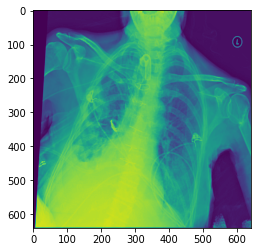

In [12]:
plt.imshow(values[0][0])

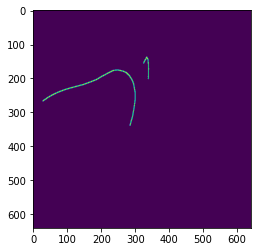

In [17]:
plt.imshow(values[3])

In [14]:
values[1]

tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0])

In [16]:
values[4]

True

In [ ]:
plt.imshow(values[4])

In [ ]:
plt.imshow(values[0][0])

In [ ]:
values[3].sum((1,2))

In [ ]:
r = temp_model(torch.unsqueeze(values[0], dim=0))

In [ ]:
r[2]

In [ ]:
out[0].sum((1,2))

In [ ]:
out.detach()[0][2].max()

In [ ]:
idx = 9

plt.imshow(out.detach()[0][idx+1])
plt.show()
plt.imshow(values[3][idx])
plt.show()

In [ ]:
'/data/tube_masks_channel_640_640/'

In [ ]:
values = dataset_seg[10]
values[-1]

In [ ]:
plt.figure(figsize=(10,10))

plt.imshow(values[0][0])

In [ ]:
plt.imshow(values[3][9])

In [ ]:
temp_mask

In [ ]:
plt.imshow(temp_im[1])

In [ ]:
plt.imshow(temp_im[2])

In [ ]:
temp_im[:].min(), temp_im[:].max()

In [ ]:
plt.imshow(temp_mask[0])

In [ ]:
temp_mask[0].unique()

In [ ]:
temp_im, temp_target = dataset[11]

print(temp_target)

plt.imshow(temp_im)

In [ ]:
temp_im.shape

In [ ]:
dataset.labels.shape

In [ ]:
plt.imshow(np.stack([temp_im,temp_im,temp_im], axis=-1))

In [ ]:
((512 - 76) * (404 - 0)) / (512*512)

In [ ]:
alpha = 0.2

plt.hist(np.random.beta(alpha,alpha,1000))

In [ ]:
dataloder = torch.utils.data.DataLoader(dataset_seg, batch_size=8)
for batch in dataloder:
    break
batch

In [ ]:
batch[1][6][1].unique()

# Model

In [ ]:
model = smp.Unet(
    in_channels=3,
    encoder_name='densenet121', 
    encoder_weights=None, 
    classes=2, 
    activation='sigmoid',
    aux_params=dict(
        pooling='avg',             # one of 'avg', 'max'
        dropout=None,               # dropout ratio, default is None
        classes=4,                 # define number of output labels
    )
)

In [ ]:
model.classification_head[3] = torch.nn.Identity()

In [ ]:
from models.utils import load_effnet_b5_start_point, load_resnet200d_start_point

In [ ]:
from collections import OrderedDict

def load_densenet121_start_point(path: str):
    start_point = torch.load(path, map_location="cpu")

    new_start_point = OrderedDict()

    for k, v in start_point["model"].items():
        if k.startswith("classifier"):
            new_start_point[k] = v
        else:
            # Ignore `.module` at the begining
            new_start_point[k[6:]] = v

    return new_start_point

In [ ]:
densenet_state_dict = load_densenet121_start_point('/data/additional_data/startingpoints/densenet121_chestx.pth')

In [ ]:
model.classification_head

In [ ]:
densenet_state_dict['features.conv0.weight']

In [ ]:
model.encoder.features.conv0.weight

In [ ]:
state_dict = load_resnet200d_start_point('/data/additional_data/startingpoints/densenet121_chestx.pth')

In [ ]:
model.encoder.load_state_dict(state_dict)

In [ ]:
chkp = torch.load('../logdirs/fpn_se_resnext50_32x4d_imagenet_20bs_512res_qubvelaugs_shedchanged/fold_0/checkpoints/best.pth', map_location='cpu')

In [ ]:
model.load_state_dict(chkp['model_state_dict'])

model.eval();

In [ ]:
out = model(batch[0])

In [ ]:
plt.imshow(batch[1][7,1])

In [ ]:
512*512

In [ ]:
batch[1][0,1].sum()

In [ ]:
plt.imshow(out[7,1].detach().cpu())

In [ ]:
preprocessing_fn = smp.encoders.get_preprocessing_fn("se_resnext50_32x4d", "imagenet")

In [ ]:
preprocessing_fn

In [ ]:
model.segmentation_head

In [ ]:
out = model(batch[0])

In [ ]:
out.shape

In [ ]:
batch[1].shape

In [ ]:
loss_tube = smp.utils.losses.DiceLoss()
loss_lung = smp.utils.losses.DiceLoss()

In [ ]:
loss_tube(out[:,0,:,:], batch[1][:,0,:,:])

In [ ]:
loss_lung(out[:,1,:,:], batch[1][:,1,:,:])

In [ ]:
timm_model_csv = pd.read_csv('../../pytorch-image-models/results/results-imagenet-a-clean.csv')
timm_model_csv

In [ ]:
timm.list_models()

In [ ]:
model = timm.create_model('tf_efficientnet_b3_ns', pretrained=True)

In [ ]:
model.stem.conv.in_channels = 1
weight = model.stem.conv.weight.mean(1, keepdim=True)
model.stem.conv.weight = torch.nn.Parameter(weight)

In [ ]:
model

In [ ]:
model.(torch.randn((1,3,384,384))).shape

In [ ]:
model(torch.randn((1,3,384,384))).shape

In [ ]:
timm.list_models()

In [ ]:
from models import CNNModel

In [ ]:
model = CNNModel(
    classifiier_config={
        "classifier_type":'relu',
        "classes_num":5,
        "hidden_dims":256,
        "second_dropout_rate":0.2,
        "first_dropout_rate":0.3,        
    },
    encoder_type="effnet3",
    device="cpu"
)

In [ ]:
#model = model.float()

# Loss

In [ ]:
from losses import StrongCE

In [ ]:
loss = StrongCE()

In [ ]:
out = loss.forward(batch, model)

In [ ]:
out

# Metric

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(
    out[1].detach().cpu().argmax(-1).numpy(),
    out[2].detach().cpu().argmax(-1).numpy()
)

# Copy CHESTX

In [ ]:
from tqdm import tqdm

from shutil import copyfile
from os.path import basename

In [ ]:
all_files = glob('/data/additional_data/chestx/all_images/*.png')

len(all_files)

In [ ]:
for f in tqdm(all_files):
    copyfile(
        f,
        pjoin('/data/additional_data/chestx/all_images/', basename(f))
    )